In [1]:
import numpy as np
from scipy.sparse.linalg import lsmr
import workload
import matplotlib.pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
def error(WtW, A, noise):
    # || W A^+ noise ||_F^2
    noise2 = lsmr(A, noise)[0]
    return np.dot(noise2, WtW.dot(noise2))

def error_and_grad(WtW, A, noise):
    xhat = lsmr(A, noise)[0]
    err = np.dot(xhat, WtW.dot(xhat))

In [15]:
# tr[(W^T W) (A^T A)^+]
# random entry from diagonal * n

n = 128
p = 2

R = workload.AllRange(n)
WtW = R.WtW
A = np.vstack([np.eye(n), np.random.rand(p,n)])
A /= A.sum()
AtA = A.T.dot(A)
AtA1 = np.linalg.pinv(AtA)

err = np.trace(WtW.dot(AtA1))

errors1 = np.diag(WtW.dot(AtA1)) * n
Y = [np.random.laplace(0, 1.0/np.sqrt(2), n+p) for _ in range(1000)]
errors2 = [error(WtW, A, y) for y in Y]

print err, np.mean(errors1), np.mean(errors2)
print np.std(errors1), np.std(errors2)
print np.std(errors1) / np.std(errors2)



13306497338.2 13306497338.2 13509368529.1
7096635947.49 8946778908.44
0.793205691134


790.798615092 816.0


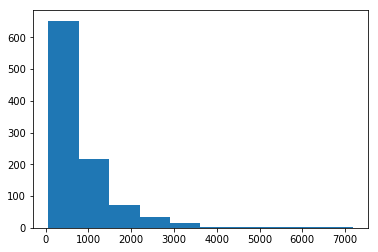

In [61]:
R = workload.AllRange(16)
A = np.eye(16)

eps = np.sqrt(2)
trials = 1000
errs = np.zeros(trials)
for i in range(trials):
    noise = np.random.laplace(loc=0, scale=1.0/eps, size=A.shape[0])
    errs[i] = error(R.WtW, A, noise)

print np.mean(errs), R.expected_error(A, eps)
plt.hist(errs)
plt.show()

In [7]:
import autograd.numpy as np
from autograd import grad

WtW = workload.AllRange(16).WtW
eps = np.random.laplace(loc=0, scale=1, size=16)

def foo(noise):
    return np.dot(noise, np.dot(WtW, noise))

def foo_grad(noise):
    return 2 * np.dot(WtW, noise)

def bar(A):
    y = eps
    x = np.linalg.lstsq(A, y)[0]
    ans = foo(x)
    dans = foo_grad(x)
    dy = np.linalg.lstsq(A.T, dans)[0]
    return ans, -np.outer(dy, x)
    
    
print foo(eps)
print grad(foo)(eps)
print foo_grad(eps)

A = np.random.rand(16, 16)
eps = np.random.laplace(loc=0, scale=1, size=A.shape[0])

ans, dA = bar(A)
approx = np.zeros(16)
for i in range(16):
    A[i,i] += 1e-5
    approx[i] = (bar(A)[0] - ans) / 1e-5
    A[i,i] -= 1e-5
    
print np.diag(dA)
print approx

#print grad(bar)(A)

IndentationError: expected an indented block (<ipython-input-7-4414926e2423>, line 25)

In [38]:
import autograd.numpy as np
from autograd import grad, primitive

def pinv_vjp(g, ans, vs, gvs, A):
    print g.shape
    A1 = np.linalg.pinv(A)
    In = np.eye(A.shape[1])
    Im = np.eye(A.shape[0])
    term1 = -np.dot(A1, np.dot(g.T, A1))
    term2 = np.dot(np.dot(A1, A1.T), np.dot(g, Im - np.dot(A, A1)))
    term3 = np.dot(In - np.dot(A1, A), np.dot(g, np.dot(A1.T, A1)))
    term3 = 0
    return (term1 + term2 + term3).T

np.linalg.pinv.defvjp(pinv_vjp)

def obj(A, WtW, y):
    A1 = np.linalg.pinv(A)
    z = np.dot(A1, y)
    return np.dot(z, np.dot(WtW, z))

WtW = workload.AllRange(16).WtW
A = np.random.rand(18, 16)
#A = np.eye(16)
y = np.random.rand(A.shape[0])
ans = obj(A, WtW, y)
deriv = grad(obj)(A, WtW, y)
print ans
print np.diag(deriv)

approx = np.zeros(16)
for i in range(16):
    A[i,i] += 1e-5
    approx[i] = (obj(A, WtW, y) - ans) / 1e-5
    A[i,i] -= 1e-5
print approx

(16, 18)
83.5621048743
[   6.97064706   25.90708175    4.27219979   34.28495373  -39.30391356
  -55.74956823  -28.40468225  -32.9907413    28.09065462  -15.04501773
   89.34666318 -145.95673224   26.64042942  -27.80061426   20.9186458
   -2.35334495]
[   6.97039436   25.90718936    4.27216904   34.28480524  -39.30334966
  -55.74860026  -28.40463153  -32.99004593   28.09127895  -15.04480303
   89.34948643 -145.95236898   26.64053372  -27.80086502   20.91884488
   -2.35321392]


In [251]:
import autograd.numpy as np
def loss(A, WtW, y):
    z = np.dot(A.T, y)
    AtA = np.dot(A.T, A)
    AtA1 = np.linalg.inv(AtA)
    x = np.dot(AtA1, z)
    return np.dot(x, np.dot(WtW, x))

def loss_and_grad(A, WtW, y):
    #C(A) = f(z(B(A)))
    p, n = A.shape
    
    B = np.linalg.pinv(A)
    z = B.dot(y)
    dz = 2*WtW.dot(z)
    ans = z.dot(dz) / 2.0
    dB = np.outer(dz, y)
    
    term1 = -B.dot(dB.T).dot(B)
    term2 = B.dot(B.T).dot(dB).dot(np.eye(p) - A.dot(B))
    term3 = (np.eye(n) - B.dot(A)).dot(dB).dot(B.T).dot(B)
    dA = (term1 + term2 + term3).T
    return ans, dA

WtW = workload.AllRange(16).WtW
A = np.random.rand(18, 16)
y = np.random.rand(A.shape[0])
print loss(A, WtW, y)
print np.diag(grad(loss)(A, WtW, y))
print np.diag(loss_and_grad(A, WtW, y)[1])

663.595555733
[  104.93968784   484.03399817   326.48745269   508.61416362  -270.85973181
  -184.25244439  1659.41024483   -75.10926425  -799.82494044 -1256.76878524
   183.02638959   -17.67771646  1043.57259764   -82.21142497  -503.52976131
  -117.99076554]
[  104.93968784   484.03399817   326.48745269   508.61416362  -270.85973181
  -184.25244439  1659.41024483   -75.10926425  -799.82494044 -1256.76878524
   183.02638959   -17.67771646  1043.57259764   -82.21142497  -503.52976131
  -117.99076554]


In [252]:
from scipy import sparse
from scipy.sparse.linalg import lsmr, lsqr
import time

def lstsq(A, y):
    #return lsqr(A, y, atol=0, btol=0)[0]
    return lsqr(A, y)[0]

def loss_and_grad2(A, WtW, y):
    p, n = A.shape
    At = A.T
    # B = inv(A)
    z = lstsq(A, y)
    dz = 2 * WtW.dot(z)
    ans = z.dot(dz) / 2.0
    # dB = outer(dz, y)
    
    # term1 = -outer(z, a)
    a = lstsq(At, dz)
    #term2 = outer(b, c)
    b = lstsq(A, a)
    c = y - lstsq(At, At.dot(y))
    # term3 = outer(d, e)
    d = dz - lstsq(A, A.dot(dz))
    e = lstsq(At, z)
    
    grad = [(-a, z), (c,b), (e,d)] #-np.outer(z, a) + np.outer(b, c) + np.outer(d, e)
    
    return ans, grad
    
    
WtW = workload.AllRange(16).WtW
A = np.random.rand(18, 16)
y = np.random.rand(A.shape[0])

ans, dA = loss_and_grad(A, WtW, y)
ans2, dA2 = loss_and_grad2(A, WtW, y)

dA = grad(loss)(A, WtW, y)

print ans, ans2
print dA[0]
print sum(np.outer(a,b) for a,b in dA2)[0]

179.207787254 179.20778725
[-179.34944549   91.77100996 -133.76617664 -135.92645389 -110.56727909
   -8.8794189   165.06418746   84.4321942   -31.29657449  -84.41388483
 -142.39572946   69.5555711   -40.6118268   142.38888507  186.24347491
  -44.09707927]
[-179.3494455    91.77100996 -133.76617664 -135.9264539  -110.56727908
   -8.8794189   165.06418747   84.43219419  -31.29657449  -84.41388483
 -142.39572947   69.5555711   -40.61182679  142.38888507  186.24347492
  -44.09707928]


In [127]:
from scipy import sparse
n = 2**13
A = np.load('/home/ryan/Desktop/strategies/all-range-%d.npy' % n)
A = sparse.csc_matrix(A)
y = np.random.rand(A.shape[0])
WtW = workload.AllRange(n).WtW

%time ans, dA = loss_and_grad2(A, WtW, y)

CPU times: user 864 ms, sys: 392 ms, total: 1.26 s
Wall time: 677 ms


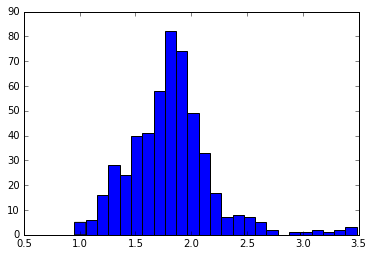

9


In [138]:
import matplotlib.pyplot as plt 
widths = (A[8192:]>1e-4).sum(axis=1)
plt.hist(np.log10(widths), bins=25)
plt.show()
print widths.min()

[16, 32, 64]
16
32
64
(25, 128) 656.0 1024


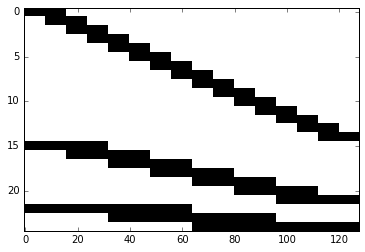

In [176]:
template = []
start = 0
n = 128
widths = [2**k for k in range(4, int(np.log2(n)))]
print widths
for width in widths:
    print width
    for start in range(0, n-width//2, width//2):
        row = np.zeros(n)
        row[start:start+width] = 1.0
        template.append(row)
template = np.array(template)
print template.shape, template.sum(), n**2/16
plt.imshow(template, cmap='Greys', interpolation='nearest', aspect='auto')
#plt.savefig('sparse_structure.png')
plt.show()
#print np.nonzero(template)

In [258]:
#dA = outer(u, v)
import autograd.numpy as np

def foo(A, WtW, y):
    z = np.dot(A.T, y)
    return np.dot(z, np.dot(WtW, z))

def grad_foo(A, WtW, y):
    z = np.dot(A.T, y)
    dz = 2*np.dot(WtW, z)
    ans = np.dot(z, dz) / 2.0
    return y, dz

def bar(B, C, WtW, y):
    A = np.kron(B,C)
    return foo(A, WtW, y)

def grad_bar(B, C, WtW,y):
    A = np.kron(B,C)
    u, v = grad_foo(A, WtW, y)
    m1, n1 = B.shape
    m2, n2 = C.shape
    U = u.reshape(m1, m2)
    V = v.reshape(n1, n2)
    return U.dot(C.dot(V.T))


m, n = 20, 12
B = np.random.rand(4,3)
C = np.random.rand(5,4)

A = np.kron(B,C)

W = np.random.rand(n,n)
WtW = W.T.dot(W)
y = np.random.rand(m)

print grad(foo)(A, WtW, y)[0]
print np.outer(*grad_foo(A, WtW, y))[0]

print grad(bar)(B,C,WtW,y)
print grad_bar(B,C,WtW,y)

def baz(B, C, WtW, y):
    A = np.kron(B,C)
    return loss(A, WtW, y)

def grad_baz(B, C, WtW,y):
    A = np.kron(B, C)
    _, uvs = loss_and_grad2(A, WtW, y)
    dB = np.zeros_like(B)
    dC = np.zeros_like(C)
    m1, n1 = B.shape
    m2, n2 = C.shape
    for u, v in uvs:
        U = u.reshape(m1, m2)
        V = v.reshape(n1, n2)
        dB += U.dot(C.dot(V.T))
        dC += U.T.dot(B.dot(V))
    return dB, dC

print '\n\n\n'
print grad(baz, 1)(B, C, WtW, y)
dB, dC = grad_baz(B, C, WtW, y)
print dC

[  66.53041457   62.15312621  109.86254046   82.56079335  110.69948976
   90.4097529    71.94085766   94.78457929  100.32499964   80.19494236
   89.47779037   81.15392008]
[  66.53041457   62.15312621  109.86254046   82.56079335  110.69948976
   90.4097529    71.94085766   94.78457929  100.32499964   80.19494236
   89.47779037   81.15392008]
[[ 1208.21514249  1353.10439543  1313.24346302]
 [ 1078.87097805  1208.79337375  1185.72571342]
 [  497.59358282   548.31803139   542.08289253]
 [ 1215.71454752  1377.1657356   1325.27683612]]
[[ 1208.21514249  1353.10439543  1313.24346302]
 [ 1078.87097805  1208.79337375  1185.72571342]
 [  497.59358282   548.31803139   542.08289253]
 [ 1215.71454752  1377.1657356   1325.27683612]]




[[  918.5822106   -184.80159329   186.20989434 -1281.55502987]
 [ 1043.1651594   1394.88855503   121.01657905 -2805.04129276]
 [   78.85106663   548.64729574   -25.96357131  -595.29064053]
 [-1431.85885146 -1781.34758336  -154.51265898  3761.78757368]
 [   92.273911

In [257]:
grad?